In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [6]:
TRAIN_SIZE=101726
BATCH_SIZE=256
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
DATASET_ID = 'starling'

In [8]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [9]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [10]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [11]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [12]:
spec, index, indv  = next(iter(dataset))

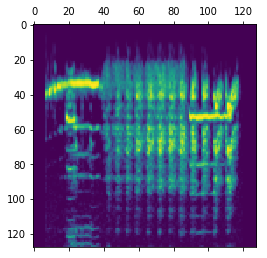

In [13]:
plt.matshow(spec.numpy().reshape(DIMS[:2]))

In [14]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [15]:
N_Z = 128

encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME"
    ),
]
def vaegan_discrim():
    inputs = tf.keras.layers.Input(shape=DIMS)
    conv1 = tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
            )(inputs)
    conv2 = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
            )(conv1)
    conv3 = tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    )(conv2)
    conv4 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    )(conv3)
    conv5 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    )(conv4)
    lastlayer = tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="tanh"
    )(conv5)
    flatten = tf.keras.layers.Flatten()(lastlayer)
    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)
    return inputs, lastlayer, outputs

"""def vaegan_discrim():
    inputs = tf.keras.layers.Input(shape=DIMS)
    flatten = tf.keras.layers.Flatten()(inputs)
    lastlayer = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)(flatten)
    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)
    return inputs, lastlayer, outputs"""

'def vaegan_discrim():\n    inputs = tf.keras.layers.Input(shape=DIMS)\n    flatten = tf.keras.layers.Flatten()(inputs)\n    lastlayer = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)(flatten)\n    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)\n    return inputs, lastlayer, outputs'

In [16]:
from avgn.tensorflow.VAEGAN2 import VAEGAN, plot_reconstruction, plot_losses

# model
model = VAEGAN(
    enc = encoder,
    dec = decoder,
    vae_disc_function = vaegan_discrim,
    lr_base_gen = 1e-3, # 
    lr_base_disc = 1e-4, # the discriminator's job is easier than the generators so make the learning rate lower
    latent_loss_div=1, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
    sig_mult = 20, # how binary the discriminator's learning rate is shifted (we squash it with a sigmoid)
    recon_loss_div = 1e-5, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
)

In [17]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [18]:
model.train_net(example_data)

W1031 21:39:18.761565 140164520445696 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
    'enc_loss',
    'dec_loss',
    'disc_loss',
])

In [20]:
N_TRAIN_BATCHES = 100
N_TEST_BATCHES = 20

In [47]:
n_epochs = 5000
epoch = 0

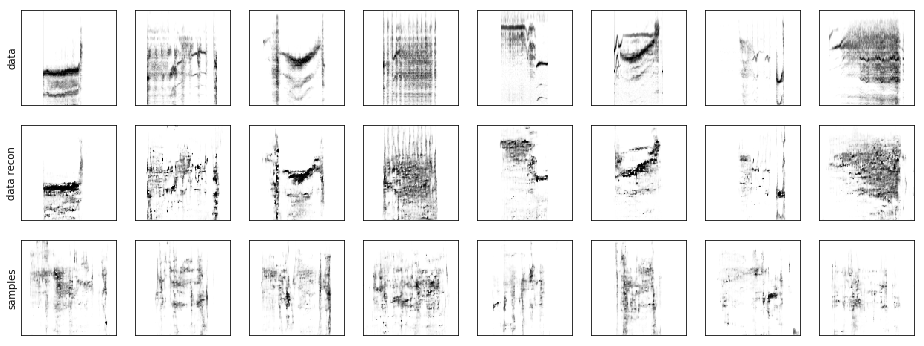

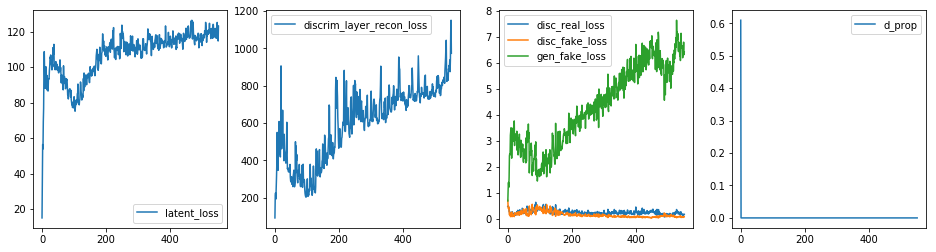

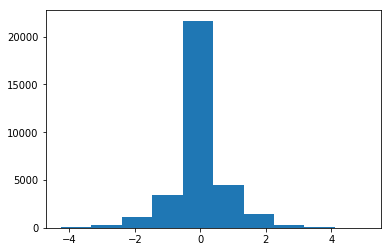

KeyboardInterrupt: 

In [48]:
for epoch in range(epoch, n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()

    plot_reconstruction(model, example_data, BATCH_SIZE, N_Z=N_Z)
    
    plot_losses(losses)
    
    z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
    plt.hist(z.flatten())
    plt.show()

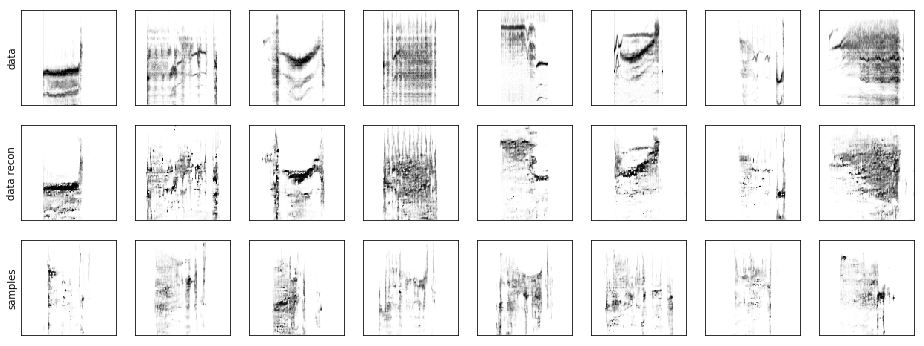

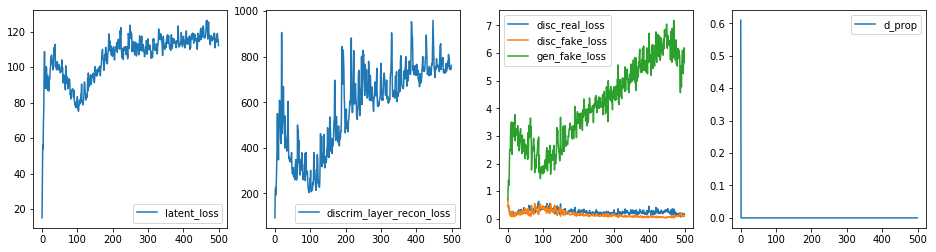

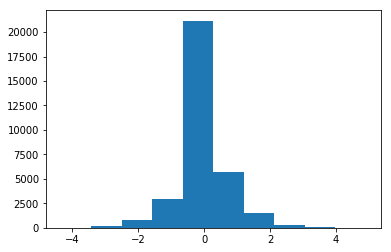

In [23]:
plot_reconstruction(model, example_data, BATCH_SIZE, N_Z=N_Z)

plot_losses(losses)

z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
plt.hist(z.flatten())
plt.show()

### Save model

In [29]:
network_type = 'VAEGAN2'

In [30]:
save_loc = DATA_DIR / 'models' / network_type / DATASET_ID

ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

#model.load_weights('/local/home/tsainbur/github_repos/avgn_paper/data/models/AE/european_starling_gentner_segmented/0347') 


### J Diagram

In [49]:
gen_func =  model.decode
interp_len = 5

In [50]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [51]:
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [52]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
exdat = np.vstack([x1, x2, x3])

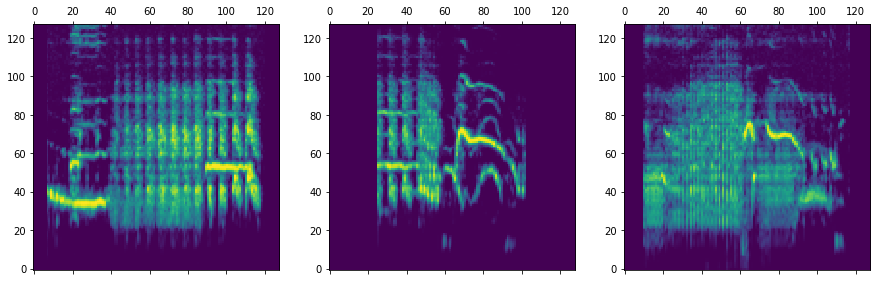

In [53]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

In [54]:
(pt1, pt2, pt3), _  = model.encode(exdat)

In [56]:
xr1, xr2, xr3 = model.decode(np.vstack([pt1, pt2, pt3]),apply_sigmoid=True)

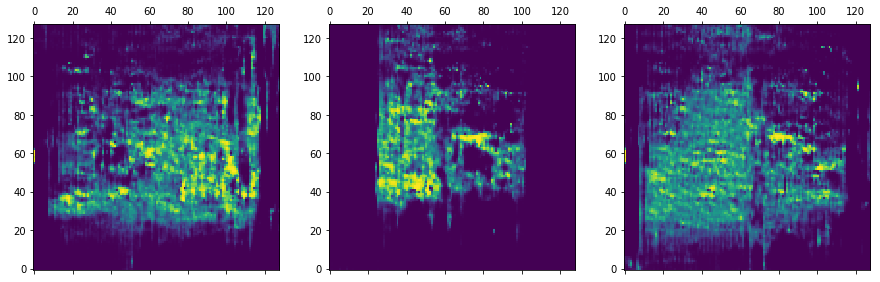

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(xr1.numpy()), origin='lower')
axs[1].matshow(np.squeeze(xr2.numpy()), origin='lower')
axs[2].matshow(np.squeeze(xr3.numpy()), origin='lower')

In [45]:
# pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

# get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(C * pt1 + B * pt2 + A * pt3)
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list, apply_sigmoid = True).numpy()

# make diagram
Jdiagram = np.ones(
    (
        x_list.shape[1] * (interp_len),
        x_list.shape[2] * (interp_len + 2),
        x_list.shape[3],
    )
)
np.shape(Jdiagram)

# populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[
            (interp_len - 1 - bi)
            * x_list.shape[1] : ((interp_len - bi))
            * x_list.shape[1],
            (ci + 1) * x_list.shape[2] : (ci + 2) * x_list.shape[2],
            :,
        ] = x_list[i]
        i += 1
Jdiagram[
    (interp_len - 1) * x_list.shape[1] : (interp_len) * x_list.shape[1],
    : x_list.shape[2],
    :,
] = x3

Jdiagram[
    (interp_len - 1) * x_list.shape[1] : (interp_len) * x_list.shape[1],
    (interp_len + 1) * x_list.shape[2] : (interp_len + 2) * x_list.shape[2],
    :,
] = x1

Jdiagram[: x_list.shape[1], : x_list.shape[2], :] = x2

(-0.5, 895.5, -0.5, 639.5)

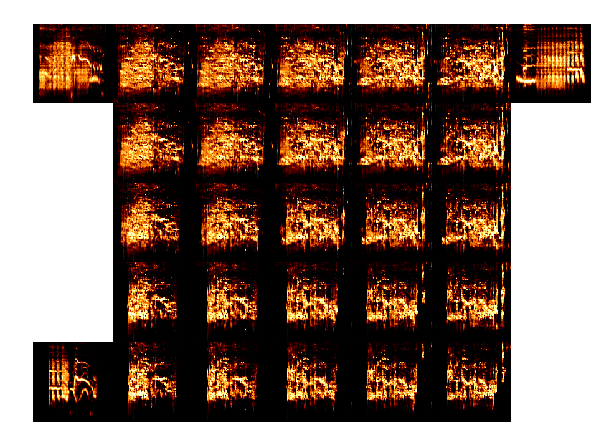

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
#save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('AE_JDiagram_2'), dpi=300, save_jpg=True)

In [ ]:
losses[-3:]

In [24]:
losses[-3:]

,d_prop,latent_loss,discrim_layer_recon_loss,gen_fake_loss,disc_fake_loss,disc_real_loss,enc_loss,dec_loss,disc_loss
497,0.0,114.492409,742.861511,5.637290,0.104803,0.165018,857.354126,748.498901,0.269821
498,0.0,115.324814,756.169556,6.184477,0.083503,0.189539,871.494324,762.354187,0.273042
499,0.0,112.114708,761.666809,5.659010,0.087570,0.155012,873.781616,767.325989,0.242582


### Plot samples from latent

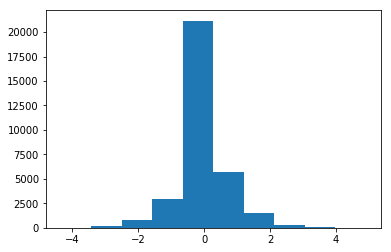

In [25]:
z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()
plt.hist(z.flatten())
plt.show()

In [26]:
np.shape(z)

(256, 128)

In [27]:
np.max(z)

4.890053

In [28]:
xmax, ymax = np.max(z, axis=0)
xmin, ymin = np.min(z, axis=0)
print(xmax, ymax, xmin, ymin)

ValueError: too many values to unpack (expected 2)

In [ ]:
# sample from grid
nx = ny= 20
meshgrid = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, DIMS[0], DIMS[1], DIMS[2])
# fill canvas
canvas = np.zeros((nx*DIMS[0], ny*DIMS[1]))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*DIMS[0]:xi*DIMS[0]+DIMS[0], yi*DIMS[1]:yi*DIMS[1]+DIMS[1]] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(canvas, vmin = 0, cmap=plt.cm.Greys, origin = 'lower')
ax.axis('off')

###  plot dataset 

In [ ]:
all_x = []
all_z = []
all_indv = []
all_labels = []
for bi, (batch, train_x) in tqdm(
    enumerate(zip(range(N_TRAIN_BATCHES), train_dataset)), total=N_TRAIN_BATCHES
):
    x = train_x[0]
    all_x.append(x)
    x = tf.cast(tf.reshape(x, [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
    #model.train_net(x)
    z = tf.split(model.enc(x), num_or_size_splits=2, axis=1)[0].numpy()
    #z = model.encode(example_data).sample().numpy()
    all_z.append(z)
    all_indv.append(train_x[3].numpy())
    all_labels.append(train_x[2].numpy())
    if bi > 100: break
all_z = np.vstack(all_z)
all_indv = np.concatenate(all_indv)
all_labels = np.concatenate(all_labels)
all_x = np.concatenate(all_x)
all_x = np.reshape(all_x, [len(all_x)] + list(DIMS[:2]))

In [ ]:
from avgn.visualization.projections import scatter_spec

In [ ]:
np.shape(all_z)

In [ ]:
plt.scatter(all_z[:,0], all_z[:,1], s=1, c='k', alpha=0.01)

In [ ]:
scatter_spec(
        np.vstack(all_z),
        all_x,
        column_size=15,
        x_range = [-4,4],
        y_range = [-4,4],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(all_labels),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
);